In [22]:
import torch
import torch.nn as nn
import numpy as np
import cv2

import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

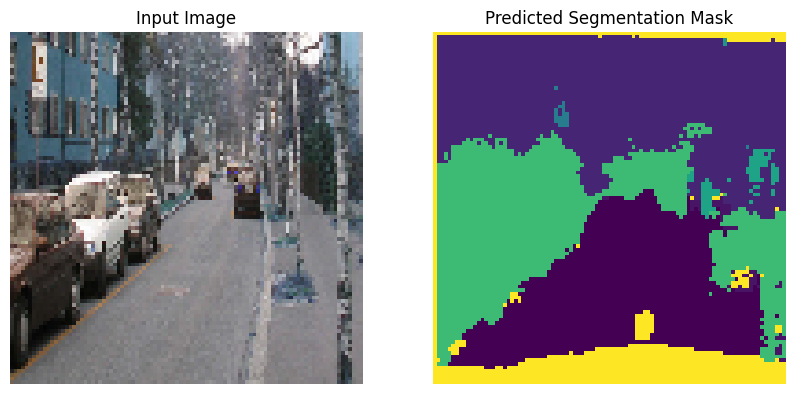

In [23]:
#modell
#create different operations of the network opearations of the network
'''
First is the single convolution layer.
convulution->batch_norm->relu
'''
class single_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        # Define the layers here
        # Note: for conv, use a padding of (1,1) so that size is maintained
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)
        self.bn = nn.BatchNorm2d(out_ch,momentum = 0.1)
        self.relu = nn.ReLU()
    def forward(self, x):
        # define forward operation using the layers above
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
'''
Second is the maxpool with indicies
'''
class down_layer(nn.Module):
    def __init__(self):
        super(down_layer, self).__init__()
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # use nn.MaxPool2d( )        
    def forward(self, x):
        x1,idx = self.down(x)
        return x1,idx

'''
Third is the unpool layer
'''
class un_pool(nn.Module):
    def __init__(self):
        super(un_pool, self).__init__()       
        self.un_pool = nn.MaxUnpool2d(kernel_size=2, stride=2) # use nn.Upsample() with mode bilinear
        
    
    def forward(self, x, idx,x1):
        #Take the indicies from maxpool layer
        x = self.un_pool(x,idx,output_size = x1.size())
        return x 
'''
Last layer is just convolution layer so we just dust define convoulution
for outlayer
'''
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        # 1 conv layer
        self.conv = nn.Conv2d(in_ch, out_ch, kernel_size=3,padding = 1)

    def forward(self, x):
        # Forward conv layer
        x = self.conv(x)
        return x

# use all above the individual operations to build the network 
class SegNet(nn.Module):
    def __init__(self, n_channels_in, n_classes):
        super(SegNet, self).__init__()
        self.conv1 = single_conv(n_channels_in,64)
        self.conv2 = single_conv(64,64)
        self.down1 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv3 = single_conv(64,128)
        self.conv4 = single_conv(128,128)
        self.down2 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv5 = single_conv(128,256)
        self.conv6 = single_conv(256,256)
        self.conv7 = single_conv(256,256)
        self.down3 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv8 = single_conv(256,512)
        self.conv9 = single_conv(512,512)
        self.conv10 = single_conv(512,512)
        self.down4 = down_layer() # Maxpool with giving max indices to do unpooling later
        self.conv11 = single_conv(512,512)
        self.conv12 = single_conv(512,512)
        self.conv13 = single_conv(512,512)
        self.down5 = down_layer()
        self.up1 = un_pool()
        self.conv14 = single_conv(512,512)
        self.conv15 = single_conv(512,512)
        self.conv16 = single_conv(512,512)
        self.up2 = un_pool()
        self.conv17 = single_conv(512,512)
        self.conv18 = single_conv(512,512)
        self.conv19 = single_conv(512,256)
        self.up3 = un_pool()
        self.conv20 = single_conv(256,256)
        self.conv21 = single_conv(256,256)
        self.conv22 = single_conv(256,128)
        self.up4 = un_pool()
        self.conv23 = single_conv(128,128)
        self.conv24 = single_conv(128,64)
        self.up5 = un_pool()
        self.conv25 = single_conv(64,64)
        self.outconv1 = outconv(64,n_classes)

    def forward(self, x):
        # Define forward pass
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3,idx1 = self.down1(x2) # skip connection <-------------------------
        x4 = self.conv3(x3)#                                                |
        x5 = self.conv4(x4)#                                                |
        x6,idx2 = self.down2(x5)# skip connection <-------------------      |
        x7 = self.conv5(x6)#                                         |      |
        x8 = self.conv6(x7)#                                         |      |
        x9 = self.conv7(x8)#                                         |      |
        x10,idx3 = self.down3(x9)# skip connection <-----------      |      |
        x11 = self.conv8(x10)#                                |      |      |
        x12 = self.conv9(x11)#                                |      |      | 
        x13 = self.conv10(x12)#                               |      |      |
        x14,idx4 = self.down4(x13)# skip connection <---      |      |      |
        x15 = self.conv11(x14)#                        |      |      |      |
        x16 = self.conv12(x15)#                        |      |      |      |
        x17 = self.conv13(x16)#                        |      |      |      |
        x18,idx5 = self.down5(x17)#                    |      |      |      |
        x19 = self.up1(x18,idx5,x17)#                  |      |      |      |
        x20 = self.conv14(x19)#                        |      |      |      |
        x21 = self.conv15(x20)#                        |      |      |      |
        x22 = self.conv16(x21)#                        |      |      |      |
        x23 = self.up2(x22,idx4,x13)# skip connection <-      |      |      |
        x24 = self.conv17(x23)#                               |      |      |
        x25 = self.conv18(x24)#                               |      |      |
        x26 = self.conv19(x25)#                               |      |      |
        x27 = self.up3(x26,idx3,x9)# skip connection <---------      |      |
        x28 = self.conv20(x27)#                                      |      |
        x29 = self.conv21(x28)#                                      |      |
        x30 = self.conv22(x29)#                                      |      |
        x31 = self.up4(x30,idx2,x5)# skip connection <----------------      |                                
        x32 = self.conv23(x31)#                                             |
        x33 = self.conv24(x32)#                                             |
        x34 = self.up4(x33,idx1,x2)# skip connection <-----------------------
        x35 = self.conv25(x34)
        x = self.outconv1(x35)
        ## Go up back to original dimension
        return x    
    


def predict_segmentation(image_path, net, device):
  # Load image
  image = cv2.imread(image_path)

  # resize and normalize as in your training
  image = cv2.resize(image, (96, 96)) 
  image = image / 255.0
  image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(image, 0)
  
  # Convert to tensor
  image_tensor = torch.Tensor(image)

  # Use Model to predict
  image_tensor = image_tensor.to(device)

  net.eval()

  with torch.no_grad():
     output = net(image_tensor)
  _, predicted_segmentation = torch.max(output.data, 1) 

  input_image_transformed = np.transpose(image_tensor.squeeze(0).cpu().numpy(), (1, 2, 0))
  
  return input_image_transformed, predicted_segmentation 

# Loading model
model = SegNet(3,20) #one additional class for pixel ignored

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

#load the best model
model_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/net_epoch27.pth"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))


# Predict Segmentation
image_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/web/images/image_1_real.jpg"
image, predicted_segmentation = predict_segmentation(image_path, model, device)

# Visualize segmentation and input image
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image
axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Input Image')

# Plot the predicted segmentation mask
axs[1].imshow(predicted_segmentation.squeeze().cpu().numpy())
axs[1].axis('off')
axs[1].set_title('Predicted Segmentation Mask')

# Show the plot
plt.show()

In [29]:
import os

# Define a function to predict and visualize segmentation
def predict_and_visualize(image_path, net, device, epoch):
    image, predicted_segmentation = predict_segmentation(image_path, net, device)

    # Plotting and visualization
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the input image
    axs[0].imshow(image)
    axs[0].axis('off')
    axs[0].set_title('Input Image')

    # Plot the predicted segmentation mask
    axs[1].imshow(predicted_segmentation.squeeze().cpu().numpy())
    axs[1].axis('off')
    axs[1].set_title(f'Predicted Segmentation Mask - Epoch {epoch}')

    # Export the figure for each epoch
    plt.savefig(f'prediction_epoch_{epoch}.png')
    plt.close()

# Loading model
model = SegNet(3, 20)  # one additional class for pixel ignored

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the directory where epoch models are stored
epoch_models_directory = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/train/"
image_path = "/Users/severin/Documents/GitHub/u-net-segmentation-of-streets-and-cars/web/images/image_3_test.jpg"

# Loop through epoch models
for epoch in range(1, 35):  # Assuming you have models from epoch 1 to 6
    # Load the corresponding model for this epoch
    model_path = os.path.join(epoch_models_directory, f"net_epoch{epoch}.pth")
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    # Predict and visualize segmentation for the current epoch
    predict_and_visualize(image_path, model, device, epoch)


In [38]:
import os
import glob
import imageio
from natsort import natsorted

top_epochs = [2, 9, 11, 12, 13, 14, 19, 20, 27]

def create_gif_from_directory(directory_path, gif_path, pattern="prediction_epoch*.png", duration=0.5):
    image_paths = glob.glob(os.path.join(directory_path, pattern))
    image_paths = natsorted(image_paths)  # Use natsorted for natural sorting

    images = []
    for path in image_paths:
        images.append(imageio.imread(path))

    # Save images as a GIF
    imageio.mimsave(gif_path, images, duration=duration)

# Example usage:
directory_path = ""  # Update this with your directory path containing images
gif_output_path = "segmentation_results.gif"

create_gif_from_directory(directory_path, gif_output_path)

def create_gif_from_directory(directory_path, gif_path, pattern="prediction_epoch*.png", duration=1000):

    images = []
    for epoch in top_epochs:

        images.append(imageio.imread(f"prediction_epoch_{epoch}.png"))

    # Save images as a GIF
    imageio.mimsave(gif_path, images, duration=duration)

# Example usage:
directory_path = ""  # Update this with your directory path containing images
gif_output_path = "segmentation_results_top.gif"

create_gif_from_directory(directory_path, gif_output_path)

/var/folders/6b/xtl7vy6938n0dnfml7qyq69h0000gn/T/ipykernel_29930/2960627247.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(path))
/var/folders/6b/xtl7vy6938n0dnfml7qyq69h0000gn/T/ipykernel_29930/2960627247.py:30: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f"prediction_epoch_{epoch}.png"))
